In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
import numpy as np


In [2]:
bids_df= pd.read_csv('data/bids.csv')
train_df = pd.read_csv('data/train.csv')
test_df= pd.read_csv('data/test.csv')

In [3]:
bids_df

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3
...,...,...,...,...,...,...,...,...,...
7656329,7656329,626159dd6f2228ede002d9f9340f75b7puk8d,3e64w,jewelry,phone91,9709222052631578,ru,140.204.227.63,cghhmomsaxi6pug
7656330,7656330,a318ea333ceee1ba39a494476386136a826dv,xn0y0,mobile,phone236,9709222052631578,pl,24.232.159.118,wgggpdg2gx5pesn
7656331,7656331,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,gja6c,sporting goods,phone80,9709222052631578,za,80.237.28.246,5xgysg14grlersa
7656332,7656332,d4bd412590f5106b9d887a43c51b254eldo4f,hmwk8,jewelry,phone349,9709222052631578,my,91.162.27.152,bhtrek44bzi2wfl


# Feature Engineering

In [4]:
bids_unique= bids_df.groupby('bidder_id').nunique()
bids_unique = bids_unique.drop(["bid_id"],axis = 1)

In [5]:
bids_unique = bids_unique.drop(["bidder_id"],axis = 1)

#### From bids_unique dataframe, we may be interested in the number of times a bidder has 
1. Bidded in a different auction
2. Bidded from a different url
3. Bidded on a different device
4. Bidded from a different country

In [6]:
bids_unique

,auction,merchandise,device,time,country,ip,url
bidder_id,,,,,,,
001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1,1
002d229ffb247009810828f648afc2ef593rb,1,1,2,2,1,1,1
0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1,1
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3,1,3,3,1,3,2
00486a11dff552c4bd7696265724ff81yeo9v,13,1,8,20,1,10,7
...,...,...,...,...,...,...,...
ffbc0fdfbf19a8a9116b68714138f2902cc13,637,1,792,23487,102,18726,8039
ffc4e2dd2cc08249f299cab46ecbfacfobmr3,15,1,13,22,6,18,12
ffd29eb307a4c54610dd2d3d212bf3bagmmpl,1,1,1,1,1,1,1


In [7]:
bids_df_count= bids_df.groupby("bidder_id")
counts= bids_df_count['url'].count().reset_index().rename(columns = {'url':'num_bids'})

Working for additonal features

In [50]:
end_auction_time= bids_df.groupby('auction').time.max().reset_index()
end_auction_time= end_auction_time.rename(columns= {'time': 'endtime'})
start_auction_time= bids_df.groupby('auction').time.min().reset_index()
start_auction_time= start_auction_time.rename(columns= {'time': 'starttime'})
start_end_times= pd.merge(start_auction_time, end_auction_time, on= 'auction', how= 'left')
start_end_times = start_end_times.set_index('auction')


timing_dict = start_end_times.to_dict('index')
print(timing_dict)
# start_end_times


{'00270': {'starttime': 9699049894736842, 'endtime': 9709212894736842}, '008vv': {'starttime': 9759369421052631, 'endtime': 9760397157894736}, '00cwr': {'starttime': 9695641631578947, 'endtime': 9698636578947368}, '00do0': {'starttime': 9759323842105263, 'endtime': 9759865210526315}, '00hjy': {'starttime': 9759410368421052, 'endtime': 9772723842105263}, '00hm5': {'starttime': 9631995947368421, 'endtime': 9645556947368421}, '00llo': {'starttime': 9761694578947368, 'endtime': 9766805473684210}, '00mip': {'starttime': 9763924947368421, 'endtime': 9763924947368421}, '00p4a': {'starttime': 9764189736842105, 'endtime': 9764189736842105}, '00sj9': {'starttime': 9635670789473684, 'endtime': 9709079473684210}, '010lx': {'starttime': 9637005526315789, 'endtime': 9641418210526315}, '012sd': {'starttime': 9759251421052631, 'endtime': 9762374421052631}, '012wh': {'starttime': 9759243526315789, 'endtime': 9772884684210526}, '0143v': {'starttime': 9632040263157894, 'endtime': 9708988157894736}, '014m

In [45]:
def find_time_to_bid(auction_id, time):
    starttime = timing_dict[auction_id]['starttime']
    return int(time) - int(starttime)
    
    
# bids_df['time_to_bid'] = bids_df.apply(lambda row: find_time_to_bid(row['auction'], row['time']), axis=1)
bids_df.drop('mean_time_to_bid', axis=1)

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url,time_to_bid
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3,0
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c,0
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3,0
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3,0
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3,0
...,...,...,...,...,...,...,...,...,...,...
7656329,7656329,626159dd6f2228ede002d9f9340f75b7puk8d,3e64w,jewelry,phone91,9709222052631578,ru,140.204.227.63,cghhmomsaxi6pug,829578947368
7656330,7656330,a318ea333ceee1ba39a494476386136a826dv,xn0y0,mobile,phone236,9709222052631578,pl,24.232.159.118,wgggpdg2gx5pesn,77277789473684
7656331,7656331,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,gja6c,sporting goods,phone80,9709222052631578,za,80.237.28.246,5xgysg14grlersa,77304894736842
7656332,7656332,d4bd412590f5106b9d887a43c51b254eldo4f,hmwk8,jewelry,phone349,9709222052631578,my,91.162.27.152,bhtrek44bzi2wfl,77104157894736


In [43]:
# bids_df_time = bids_df.groupby('bidder_id')['time_to_bid'].mean()
bids_df_time = bids_df
bids_df_time_mean = bids_df_time.groupby('bidder_id')['time_to_bid'].mean().reset_index()
bids_df_time_mean

,bidder_id,time_to_bid
0,001068c415025a009fee375a12cff4fcnht8y,7.439058e+13
1,002d229ffb247009810828f648afc2ef593rb,1.455263e+11
2,0030a2dd87ad2733e0873062e4f83954mkj86,7.263689e+13
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,6.854544e+12
4,00486a11dff552c4bd7696265724ff81yeo9v,1.904773e+13
...,...,...
6609,ffbc0fdfbf19a8a9116b68714138f2902cc13,5.719356e+12
6610,ffc4e2dd2cc08249f299cab46ecbfacfobmr3,2.954407e+13
6611,ffd29eb307a4c54610dd2d3d212bf3bagmmpl,1.044305e+13
6612,ffd62646d600b759a985d45918bd6f0431vmz,5.369726e+12


In [ ]:
End of working for additional features

#### From counts dataframe, we know the number of times that a unique bidder has performed a bid 

In [8]:
counts

,bidder_id,num_bids
0,001068c415025a009fee375a12cff4fcnht8y,1
1,002d229ffb247009810828f648afc2ef593rb,2
2,0030a2dd87ad2733e0873062e4f83954mkj86,1
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3
4,00486a11dff552c4bd7696265724ff81yeo9v,20
...,...,...
6609,ffbc0fdfbf19a8a9116b68714138f2902cc13,25075
6610,ffc4e2dd2cc08249f299cab46ecbfacfobmr3,22
6611,ffd29eb307a4c54610dd2d3d212bf3bagmmpl,1
6612,ffd62646d600b759a985d45918bd6f0431vmz,664


#### Joining the new features together with the training dataset

In [9]:
new_train = train_df.merge(bids_unique, how= 'left', on = 'bidder_id')
new_train = new_train.merge(counts, how= 'left')
new_train.fillna(0,inplace = True)

new_test = test_df.merge(bids_unique, how= 'left', on = 'bidder_id')
new_test = new_test.merge(counts, how= 'left')
new_test.fillna(0,inplace = True)

In [10]:
new_train

,bidder_id,payment_account,address,outcome,auction,merchandise,device,time,country,ip,url,num_bids
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,18.0,1.0,14.0,24.0,6.0,20.0,1.0,24.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,1.0,1.0,2.0,3.0,1.0,3.0,2.0,3.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0,4.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,23.0,1.0,53.0,155.0,2.0,123.0,91.0,155.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2008,369515b3af4f8ca582f90271d30b14b6r52aw,a1f85275793c4a782f0a668711f41b927ivc9,e6882cf204a9482edd042b6e31791dfctxzx8,0.0,25.0,1.0,4.0,33.0,4.0,5.0,2.0,36.0
2009,f939c17ffc7c39ac9b35b69e5e75179fv9pe2,a3d2de7675556553a5f08e4c88d2c2286s1m2,b9b03d5a127eb07aeb9163cdcf524e1344ac9,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2010,c806dbb2decba0ed3c4ff5e2e60a74c2wjvbl,a3d2de7675556553a5f08e4c88d2c22856leq,d02c2b288b8aabd79ff47118aff41a2dqwzwc,0.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0
2011,0381a69b7a061e9ace2798fd48f1f537mgq57,fd87037ce0304077079c749f420f0b4c54uo0,f030a221726fbcdfc4dc7dfd1b381a112hieq,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### Check that the size new training and test dataset is the same as the old training and test dataset

In [11]:
print("Size of old train: " + str(train_df.shape))
print("Size of new train: " + str(new_train.shape))
print("Size of old test: " + str(test_df.shape))
print("Size of new test: " + str(new_test.shape))

Size of old train: (2013, 4)
Size of new train: (2013, 12)
Size of old test: (4700, 3)
Size of new test: (4700, 11)


#### Count of number of first and last bids for each bidder

In [12]:
auctions = bids_df.groupby('auction')
first_bid_list = set(auctions.first()['bidder_id'])
last_bid_list = set(auctions.last()['bidder_id'])

In [13]:
# functions to add a counter if a particular bidder id is in the first and/or last bid
def check_first_bid(dummy):
    count = 0
    for bidder_id in first_bid_list:
        if(dummy == bidder_id):
            count+=1
    return count
        
def check_last_bid(dummy):
    count = 0
    for bidder_id in last_bid_list:
        if(dummy == bidder_id):
            count+=1
    return count

In [14]:
num_first_bids_train = new_train['bidder_id'].apply(func = check_first_bid)
num_last_bids_train = new_train['bidder_id'].apply(func = check_last_bid)

num_first_bids_test = new_test['bidder_id'].apply(func = check_first_bid)
num_last_bids_test = new_test['bidder_id'].apply(func = check_last_bid)

In [15]:
# joining the new train and test with the number of first and last bids
new_train['num_first_bids'] = num_first_bids_train
new_train['num_last_bids'] = num_last_bids_train
new_train

,bidder_id,payment_account,address,outcome,auction,merchandise,device,time,country,ip,url,num_bids,num_first_bids,num_last_bids
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,18.0,1.0,14.0,24.0,6.0,20.0,1.0,24.0,0,0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,1.0,1.0,2.0,3.0,1.0,3.0,2.0,3.0,0,0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0,4.0,0,0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,23.0,1.0,53.0,155.0,2.0,123.0,91.0,155.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,369515b3af4f8ca582f90271d30b14b6r52aw,a1f85275793c4a782f0a668711f41b927ivc9,e6882cf204a9482edd042b6e31791dfctxzx8,0.0,25.0,1.0,4.0,33.0,4.0,5.0,2.0,36.0,1,0
2009,f939c17ffc7c39ac9b35b69e5e75179fv9pe2,a3d2de7675556553a5f08e4c88d2c2286s1m2,b9b03d5a127eb07aeb9163cdcf524e1344ac9,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0
2010,c806dbb2decba0ed3c4ff5e2e60a74c2wjvbl,a3d2de7675556553a5f08e4c88d2c22856leq,d02c2b288b8aabd79ff47118aff41a2dqwzwc,0.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,0,0
2011,0381a69b7a061e9ace2798fd48f1f537mgq57,fd87037ce0304077079c749f420f0b4c54uo0,f030a221726fbcdfc4dc7dfd1b381a112hieq,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0


In [16]:
new_test['num_first_bids'] = num_first_bids_test
new_test['num_last_bids'] = num_last_bids_test
new_test

,bidder_id,payment_account,address,auction,merchandise,device,time,country,ip,url,num_bids,num_first_bids,num_last_bids
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,a3d2de7675556553a5f08e4c88d2c228htx90,5d9fa1b71f992e7c7a106ce4b07a0a754le7c,3.0,1.0,2.0,4.0,3.0,4.0,3.0,4.0,0,0
1,a921612b85a1494456e74c09393ccb65ylp4y,a3d2de7675556553a5f08e4c88d2c228rs17i,a3d2de7675556553a5f08e4c88d2c228klidn,2.0,1.0,3.0,3.0,2.0,2.0,1.0,3.0,0,0
2,6b601e72a4d264dab9ace9d7b229b47479v6i,925381cce086b8cc9594eee1c77edf665zjpl,a3d2de7675556553a5f08e4c88d2c228aght0,14.0,1.0,4.0,17.0,3.0,4.0,2.0,17.0,0,0
3,eaf0ed0afc9689779417274b4791726cn5udi,a3d2de7675556553a5f08e4c88d2c228nclv5,b5714de1fd69d4a0d2e39d59e53fe9e15vwat,90.0,1.0,81.0,148.0,14.0,129.0,80.0,148.0,0,0
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,a3d2de7675556553a5f08e4c88d2c228dtdkd,c3b363a3c3b838d58c85acf0fc9964cb4pnfa,20.0,1.0,17.0,23.0,2.0,17.0,1.0,23.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4695,bef56983ba78b2ee064443ae95972877jfkyd,0f235a6dfea5a5885d63968826b748b4q4dra,a98a4841db165de919d29cb49d0bc306cq21h,41.0,1.0,9.0,466.0,5.0,22.0,4.0,983.0,0,0
4696,4da45cc915c32d4368ac7e773d92d4affwqrr,9e0adf7481c422654d4d0a849e0e50abiumen,e23d9777cddc347de82d839b2e54b22ecopkp,32.0,1.0,29.0,66.0,10.0,49.0,18.0,66.0,0,0
4697,0d0e6220bf59ab9a0c5b5987fb2c34a9p33f9,7df4ebd184668b4257f740b11d4519afq7kr1,b650404e1ab5d177020221277c3e9306qegyl,419.0,1.0,376.0,2156.0,86.0,1460.0,1049.0,2162.0,1,1
4698,4981c32c54dde65b79dbc48fd9ab6457caqze,a3d2de7675556553a5f08e4c88d2c2284qlm0,9c35320088eaf32046a51a96ebb2e658i479u,5.0,1.0,4.0,5.0,1.0,5.0,2.0,5.0,0,0


#### Splitting X and y

In [17]:
X = new_train.drop(columns=['bidder_id', 'payment_account', 'address', 'outcome'])
y = new_train['outcome']

#### Performing Stratified K-Fold with SMOTE

In [128]:
# def training_model(model, num_splits, X, y):
#     skfolds = StratifiedKFold(n_splits=num_splits)

#     for train_index, test_index in skfolds.split(X, y):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]
# #         print(y_train.value_counts())
        
#         sm = SMOTE()
#         X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
# #         print(y_train_oversampled.value_counts())
        
#         model = model
#         model.fit(X_train_oversampled, y_train_oversampled )  
#         y_pred = model.predict(X_test)
        
#         print(f'Accuracy: {model.score(X_test, y_test)}')
#         print(f'f-score: {f1_score(y_test, y_pred)}')

In [22]:
from sklearn import model_selection
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=40)


In [20]:
from sklearn import tree
dtree1 = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)

In [23]:
dtree1.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

[Text(153.45000000000002, 190.26, 'X[7] <= 146.0\nentropy = 0.282\nsamples = 1610\nvalue = [1531, 79]'),
 Text(83.7, 135.9, 'X[6] <= 2.5\nentropy = 0.04\nsamples = 1164\nvalue = [1159, 5]'),
 Text(55.800000000000004, 81.53999999999999, 'X[0] <= 5.5\nentropy = 0.069\nsamples = 606\nvalue = [601, 5]'),
 Text(27.900000000000002, 27.180000000000007, 'entropy = 0.079\nsamples = 513\nvalue = [508, 5]'),
 Text(83.7, 27.180000000000007, 'entropy = 0.0\nsamples = 93\nvalue = [93, 0]'),
 Text(111.60000000000001, 81.53999999999999, 'entropy = 0.0\nsamples = 558\nvalue = [558, 0]'),
 Text(223.20000000000002, 135.9, 'X[2] <= 52.0\nentropy = 0.648\nsamples = 446\nvalue = [372, 74]'),
 Text(167.4, 81.53999999999999, 'X[5] <= 13.5\nentropy = 0.989\nsamples = 64\nvalue = [36, 28]'),
 Text(139.5, 27.180000000000007, 'entropy = 0.918\nsamples = 18\nvalue = [6, 12]'),
 Text(195.3, 27.180000000000007, 'entropy = 0.932\nsamples = 46\nvalue = [30, 16]'),
 Text(279.0, 81.53999999999999, 'X[7] <= 586.5\nentrop

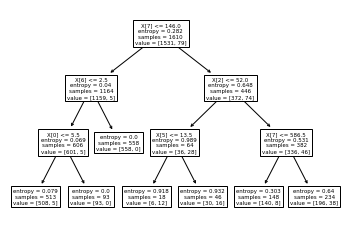

In [24]:
tree.plot_tree(dtree1)

In [ ]:
dtree1.score(x_test, y_test)